In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rioxarray as rioxr
import xarray as xr

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import rasterio
import geopandas as gpd

import pystac_client 
import planetary_computer as pc

#import iceplant_detection_functions as ipf
import lidar_sampling_functions as lsf

# Import & prepare campus lagoon data (spectral + lidar)

In [8]:
year = 2020
fp = os.path.join(os.getcwd(),'campus_lagoon_'+str(year)+'_lidar.csv')
df = pd.read_csv(fp)
df.head(3)

,Unnamed: 0,iceplant,r,g,b,nir,year,month,day,naip_id,polygon_id,geometry,lidar,max_lidar,min_lidar,min_max_diff,avg_lidar
0,0,1,78,88,69,161,2020,5,21,ca_m_3411934_sw_11_060_20200521,0,POINT (238491.48732151656 3810779.673051449),2,6,0,6,2.555556
1,1,1,85,89,70,162,2020,5,21,ca_m_3411934_sw_11_060_20200521,0,POINT (238490.9625282077 3810789.330481589),0,4,0,4,1.111111
2,2,1,74,81,70,144,2020,5,21,ca_m_3411934_sw_11_060_20200521,0,POINT (238484.5097510907 3810781.5950357113),4,6,0,6,3.111111


In [9]:
df['ndvi']=(df.nir.astype('int16') - df.r.astype('int16'))/(df.nir.astype('int16') + df.r.astype('int16'))
df.head(3)

,Unnamed: 0,iceplant,r,g,b,nir,year,month,day,naip_id,polygon_id,geometry,lidar,max_lidar,min_lidar,min_max_diff,avg_lidar,ndvi
0,0,1,78,88,69,161,2020,5,21,ca_m_3411934_sw_11_060_20200521,0,POINT (238491.48732151656 3810779.673051449),2,6,0,6,2.555556,0.347280
1,1,1,85,89,70,162,2020,5,21,ca_m_3411934_sw_11_060_20200521,0,POINT (238490.9625282077 3810789.330481589),0,4,0,4,1.111111,0.311741
2,2,1,74,81,70,144,2020,5,21,ca_m_3411934_sw_11_060_20200521,0,POINT (238484.5097510907 3810781.5950357113),4,6,0,6,3.111111,0.321101


In [10]:
df = df[['r','g','b','nir','ndvi',
         'lidar','max_lidar', 'min_lidar', 'min_max_diff', 'avg_lidar',
         'iceplant']]
df.head(3)

,r,g,b,nir,ndvi,lidar,max_lidar,min_lidar,min_max_diff,avg_lidar,iceplant
0,78,88,69,161,0.347280,2,6,0,6,2.555556,1
1,85,89,70,162,0.311741,0,4,0,4,1.111111,1
2,74,81,70,144,0.321101,4,6,0,6,3.111111,1


# Functions for rfc mode eval and assemblage
All these are `nmodel_prep_and_evals.py`

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import fbeta_score

def iceplant_proportions(labels):
    unique, counts = np.unique(labels, return_counts=True)
    print('no-iceplant:iceplant ratio    ',round(counts[0]/counts[1],1),':1')
    n = labels.shape[0]
    perc = [round(counts[0]/n*100,2), round(counts[1]/n*100,2)]
    df = pd.DataFrame({'iceplant':unique,
             'counts':counts,
             'percentage':perc}).set_index('iceplant')
    print(df)
    print()

def test_train_proportions(train_labels, test_labels):
    print('TRAIN SET COUNTS:')
    iceplant_proportions(train_labels)

    print('TEST SET COUNTS:')
    iceplant_proportions(test_labels)

    return

def print_accuracy_info(y_true,y_pred):
    N = y_true.shape[0]
    
    confmtx = confusion_matrix(y_true,y_pred)
    
    print('true negatives:', confmtx[0,0], 
          '    false positives:', confmtx[0,1])
    print('false negatives:', confmtx[1,0], 
          '    true positives:', confmtx[1,1])
    print()
    unique, counts = np.unique(y_true,return_counts=True)
    
    sens =  confmtx[1,1]/counts[1]
    spec =  confmtx[0,0]/counts[0]
    print('sensitivity (TP/P):', np.round(sens*100,2), '%')  
    print('specificity (TN/N):', np.round(spec*100,2), '%')  
    print('G-mean: ', round(np.sqrt(sens*spec),2))
    print()
    
    prec = confmtx[1,1]/(confmtx[1,1]+confmtx[0,1])
    print('precision (TP/(TP+FP)):', np.round(prec*100,2),'%' )
    print()
    
    print('MCC: ', matthews_corrcoef(y_true,y_pred))
    print()
    
    print('F1-measure: ',  round(fbeta_score(y_true, y_pred, beta=1.0),5))
    print('F0.5-measure (min false positives): ',  round(fbeta_score(y_true, y_pred, beta=0.5),5))
    print('F2-measure (min false negatives)  : ',  round(fbeta_score(y_true, y_pred, beta=2.0),5))
    print()
        
    print('accuracy:', np.round( (confmtx[1,1] + confmtx[0,0])/y_true.shape[0]*100,2),'%') # (TP + TN)/(P + N)
    return

# Rfc model with LIDAR + spectral features
## train

In [12]:
y = np.array(df['iceplant'])
X = np.array(df.drop('iceplant', axis = 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [13]:
test_train_proportions(y_train, y_test)

TRAIN SET COUNTS:
no-iceplant:iceplant ratio     3.3 :1
          counts  percentage
iceplant                    
0          17853       76.61
1           5452       23.39

TEST SET COUNTS:
no-iceplant:iceplant ratio     3.3 :1
          counts  percentage
iceplant                    
0           7647       76.56
1           2341       23.44



In [14]:
rfc = RandomForestClassifier(n_estimators = 100, random_state = 42)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## evaluate on test set 

In [15]:
predictions = rfc.predict(X_test)
print_accuracy_info(y_test, predictions)

true negatives: 7598     false positives: 49
false negatives: 43     true positives: 2298

sensitivity (TP/P): 98.16 %
specificity (TN/N): 99.36 %
G-mean:  0.99

precision (TP/(TP+FP)): 97.91 %

MCC:  0.9743590102547472

F1-measure:  0.98038
F0.5-measure (min false positives):  0.97962
F2-measure (min false negatives)  :  0.98113

accuracy: 99.08 %


## feature importance

In [16]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rfc, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

In [17]:
forest_importances = pd.Series(result.importances_mean, 
                               index=['r','g','b','nir','ndvi',
                                       'lidar','max_lidar_w', 'min_lidar_w', 'min_max_diff', 'avg_lidar_w'])
forest_importances

r               0.108200
g               0.077643
b               0.097187
nir             0.052863
ndvi            0.018302
lidar           0.006538
max_lidar_w     0.044624
min_lidar_w     0.007970
min_max_diff    0.010382
avg_lidar_w     0.034551
dtype: float64

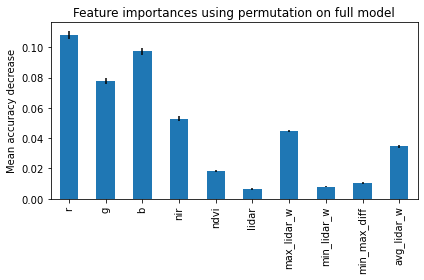

In [18]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

# Rfc model only with spectral features

## train

In [19]:
df_spectral = df.drop(['lidar','max_lidar', 'min_lidar', 'min_max_diff', 'avg_lidar'],axis=1)
y = np.array(df_spectral['iceplant'])
X = np.array(df_spectral.drop('iceplant', axis = 1)) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [20]:
rfc_spectral = RandomForestClassifier(n_estimators = 100, random_state = 42)
rfc_spectral.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## evaluate on test set

In [21]:
predictions = rfc_spectral.predict(X_test)
print_accuracy_info(y_test, predictions)

true negatives: 7516     false positives: 131
false negatives: 220     true positives: 2121

sensitivity (TP/P): 90.6 %
specificity (TN/N): 98.29 %
G-mean:  0.94

precision (TP/(TP+FP)): 94.18 %

MCC:  0.9010583322655856

F1-measure:  0.92358
F0.5-measure (min false positives):  0.93444
F2-measure (min false negatives)  :  0.91296

accuracy: 96.49 %


# Applying lidar model to NAIP aoi

## Open aoi from NAIP scene

In [22]:
aois = gpd.read_file('/home/jovyan/msai4earth-esa/iceplant_detection/areas_of_interest/areas_of_interest.shp')
cl = aois.iloc[4]  # Campus Lagoon aoi
cl

name                                              campus point
region                                                  goleta
itemid_12               ca_m_3411934_sw_11_1_20120505_20120730
itemid_14               ca_m_3411934_sw_11_1_20140601_20141030
itemid_16              ca_m_3411934_sw_11_.6_20160713_20161004
itemid_18             ca_m_3411934_sw_11_060_20180722_20190209
itemid_20                      ca_m_3411934_sw_11_060_20200521
geometry     POLYGON ((-119.8534713523 34.4028697719, -119....
Name: 4, dtype: object

In [23]:
#obtain href to NAIP scene
URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
catalog = pystac_client.Client.open(URL)

search = catalog.search(
        collections=["naip"],
        ids = cl.itemid_20        # LIDAR IS 2020
    )

item = list(search.get_items())[0]
href = pc.sign(item.assets["image"].href)

In [24]:
# clip NAIP scene to aoi
reduce = aois.iloc[[4]] # retrieve row as gpd GeoDataFrame

ds = rasterio.open(href)

#reduce = gpd.GeoDataFrame({'geometry':[reduce_box]}, crs="EPSG:4326")
reduce = reduce.to_crs(ds.crs)

In [25]:
# rioxarray of complete naip scene (two ways of getting it, second probably better?)
naip_scene = rioxr.open_rasterio(rasterio.open(href))

naip_clip = naip_scene.rio.clip_box(*reduce.total_bounds)
naip_clip.shape

(4, 1925, 1969)

## Open LIDAR raster & create features

In [26]:
fp = os.path.join(os.getcwd(),'3mlidar_over_campuspoint_naip_scene.tif')
lidar_rast_r = rasterio.open(fp)
lsf.save_min_max_diff_rasters(lidar_rast_r, os.getcwd())
lsf.save_avg_rasters(lidar_rast_r, os.getcwd())

## Match features to naip_clip (aoi)

In [27]:
def open_and_match(fp, reproject_to):
    rast = rioxr.open_rasterio(fp)
    rast_match = rast.rio.reproject_match(reproject_to)
    return rast_match.squeeze()

In [28]:
fp = os.path.join(os.getcwd(),'3mlidar_over_campuspoint_naip_scene.tif')
lidar_match = open_and_match(fp, naip_clip)

In [29]:
fp = os.path.join(os.getcwd(),'lidar_diffs.tif')
diff_match = open_and_match(fp, naip_clip)

In [30]:
fp = os.path.join(os.getcwd(),'lidar_maxs.tif')
maxs_match = open_and_match(fp, naip_clip)

In [31]:
fp = os.path.join(os.getcwd(),'lidar_mins.tif')
mins_match = open_and_match(fp, naip_clip)

In [32]:
# group to simplify adding as samples
lidar_minmax_features = np.array([
    lidar_match.to_numpy(),                             
    maxs_match.to_numpy(),
    mins_match.to_numpy(),
    diff_match.to_numpy()])

lidar_minmax_features.shape

(4, 1925, 1969)

In [33]:
fp = os.path.join(os.getcwd(),'lidar_avgs.tif')
avg_match = open_and_match(fp, naip_clip)

In [16]:
# lsf.save_raster(raster= lidar_minmax_features, 
#                 fp = os.path.join(os.getcwd(),'lidar_minmax_features.tif'),
#                 shape = (1925,1969), 
#                 bands_n = 4, 
#                 crs = mins_match.rio.crs,
#                 transform= mins_match.rio.transform(),
#                 dtype = rasterio.uint8)

In [17]:
# lsf.save_raster(raster= avg_match, 
#                 fp = os.path.join(os.getcwd(),'lidar_avg_features.tif'),
#                 shape = (1925,1969), 
#                 bands_n = 1, 
#                 crs = mins_match.rio.crs,
#                 transform= mins_match.rio.transform(),
#                 dtype = rasterio.float32)

## Sample spectral features

In [34]:
import iceplant_detection_functions_Copy1 as ipf

In [35]:
# select pixel with vegetation
image = naip_clip.to_numpy()  
veg = ipf.select_ndvi_df(image) 
veg

/home/jovyan/msai4earth-esa/iceplant_detection/model_with_lidar/iceplant_detection_functions_Copy1.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'], axis=1, inplace=True)


,r,g,b,nir
18,99,98,93,114
21,64,72,76,71
22,49,64,71,59
26,118,111,112,132
30,118,119,110,169
...,...,...,...,...
3788564,31,46,54,72
3788565,34,50,59,78
3788566,33,50,58,77
3788567,31,47,56,81


In [36]:
# add ndvi as spectral feature
veg['ndvi']=(veg.nir.astype('int16') - veg.r.astype('int16'))/(veg.nir.astype('int16') + veg.r.astype('int16'))

## Sample LIDAR features

In [22]:
# fp =  os.path.join(os.getcwd(),'lidar_minmax_features.tif')
# lidar_minmax = rasterio.open(fp).read()

# fp = os.path.join(os.getcwd(),'lidar_avg_features.tif')
# lidar_avg = rasterio.open(fp).read()

In [37]:
d = lidar_minmax_features.reshape([4,-1]).T
df_lidar = pd.DataFrame(d, columns=['lidar','max','min','diff'])
df_lidar['avg'] = avg_match.to_numpy().reshape(avg_match.shape[0]*avg_match.shape[1])

df_lidar = df_lidar.iloc[veg.index]
df_lidar

,lidar,max,min,diff,avg
18,5,7,3,4,4.555555
21,5,7,3,4,4.555555
22,5,7,3,4,4.555555
26,5,7,3,4,4.555555
30,4,7,1,6,4.222222
...,...,...,...,...,...
3788564,-9999,241,241,0,0.000000
3788565,-9999,241,241,0,0.000000
3788566,-9999,241,241,0,0.000000
3788567,-9999,241,241,0,0.000000


## Complete feature df

In [38]:
cl_features = pd.concat([veg,df_lidar],axis=1).to_numpy()

## LIDAR rfc model predictions

In [39]:
predictions = rfc.predict(cl_features)

In [40]:
# attach predictions to index of analyzed pixels
is_iceplant = pd.DataFrame(predictions, columns=['is_iceplant'], index=veg.index)

# select pixels classified as iceplant
is_iceplant = is_iceplant[is_iceplant.is_iceplant == 1]

In [41]:
preds_image = ipf.indices_backto_image(naip_clip.shape[1], naip_clip.shape[2], is_iceplant.index)

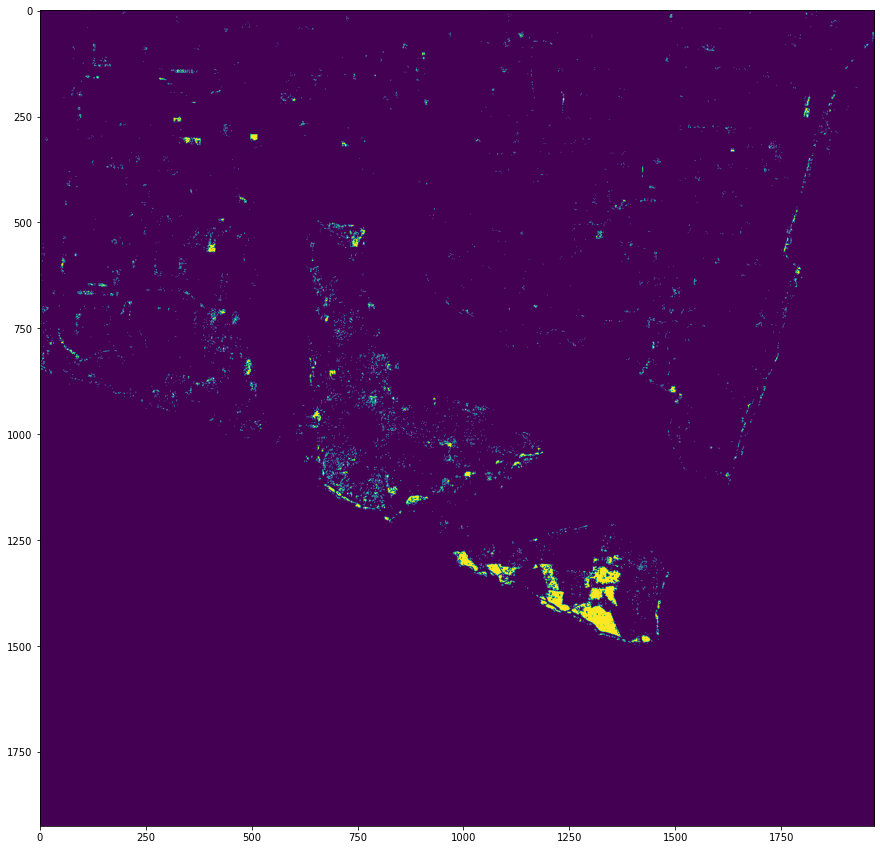

In [42]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(preds_image)
plt.show()

# Applying only spectral rfc model to aoi

In [43]:
spectral_predictions = rfc_spectral.predict(veg.to_numpy())

In [44]:
spec_is_iceplant = pd.DataFrame(spectral_predictions, columns=['is_iceplant'],index=veg.index)
spec_is_iceplant = spec_is_iceplant[spec_is_iceplant.is_iceplant == 1]

In [45]:
spec_preds_image = ipf.indices_backto_image(naip_clip.shape[1], naip_clip.shape[2],spec_is_iceplant.index)

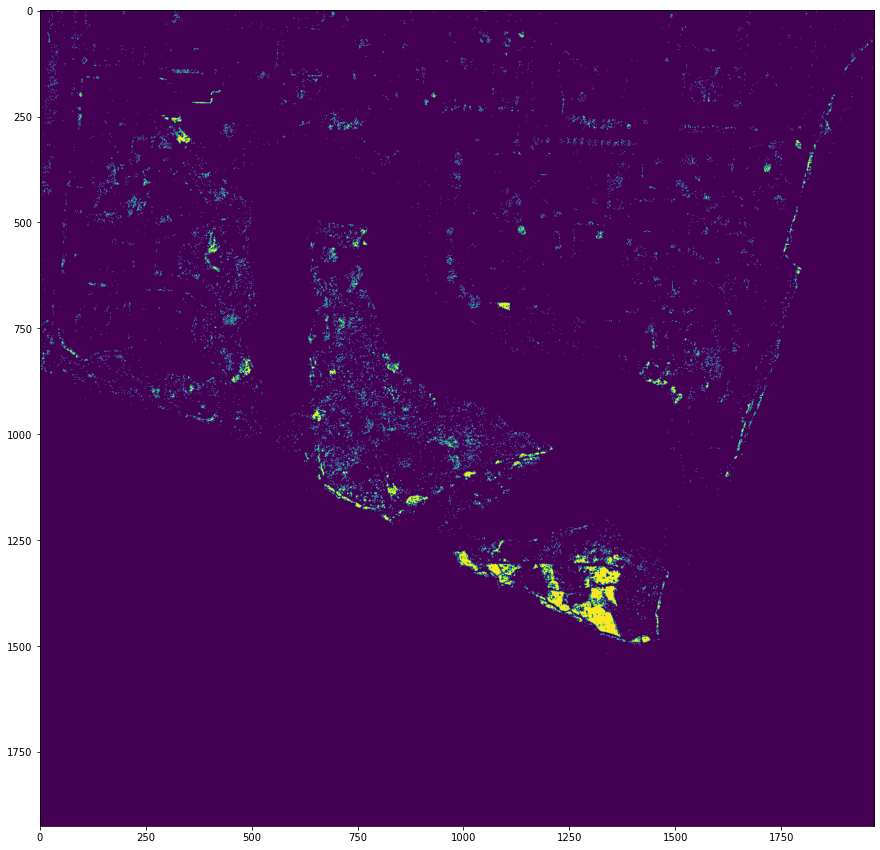

In [46]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(spec_preds_image)
plt.show()

# Save results and aoi raster

In [51]:
aoi = 'campus_lagoon'
year = 2020

In [47]:
# spectral predictions
lsf.save_raster(raster = spec_preds_image, 
                fp = os.path.join(os.getcwd(),
                                  aoi+'_spectral_predictions_'+str(year)+'.tif'),
                shape = spec_preds_image.shape, 
                bands_n = 1, 
                crs = naip_clip.rio.crs, 
                transform = naip_clip.rio.transform(), 
                dtype = rasterio.uint8)

In [48]:
# lidar predictions
lsf.save_raster(raster = preds_image, 
                fp = os.path.join(os.getcwd(), 
                                  aoi+'_lidar_predictions_'+str(year)+'.tif'),
                shape = spec_preds_image.shape, 
                bands_n = 1, 
                crs = naip_clip.rio.crs, 
                transform = naip_clip.rio.transform(), 
                dtype = rasterio.uint8)

In [50]:
# lidar predictions
lsf.save_raster(raster = naip_clip.to_numpy(), 
                fp = os.path.join(os.getcwd(),
                                  aoi+'_naip_'+str(year)+'.tif'),
                shape = (1925, 1969), 
                bands_n = 4, 
                crs = naip_clip.rio.crs, 
                transform = naip_clip.rio.transform(), 
                dtype = rasterio.uint8)

In [49]:
naip_clip.shape

(4, 1925, 1969)

In [ ]:
naip_clip